<a href="https://colab.research.google.com/github/GeoLinkCoding/EarthResources_DataScience/blob/main/Classification/Notebooks/Classification_FinalPass.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Supervised Classification Final Pass

### Introduction

This project will seek to use supervised classification techniques for fault detection with geospatial imagery. 10 rasters will be used as X data with a binary raster of fault lines as the labeled data. Training data is of an extent roughly 60x60 km northeast of Reno, NV in the United States. It will be split into training and test sets to measure model performance. Higher performing models will be applied to a dataset, without labeled data, with an extent of about 45x45 km directly north of the Vatnajökull glacier in Iceland, where the Askja Caldera/Lake resides. This area has undergone major tectonic and volcanic activity, with a major eruptive event in 1875.

X-data imagery will consist of Landsat bands 2-7 (rgb, near infrared, and 2 short-wave infrared bands), a digital elevation model (DEM), clay minerals ratio (CMI) derived from bands 6 and 7, and aspect and slope derived from the DEM. The Nevada DEM was retrieved from the US environmental protection agency (EPA) web archive. The Iceland DEM was retrieved from the University of Minnesota's FRIDGE datahub. The fault raster was created from US fault data retrieved from Esri's Living Atlas.

### Preprocessing

A detailed guide of preprocessing steps and further exploratory data analysis can be accessed on the "Classification_EDA" notebook within this repository, a must read if you don't have intuitive understanding of geospatial imagery. Regardless, here is a summary of steps taken: loaded data from GitHub repository, clipped landsat layers and handled nodata values, created CMI, resampled, clipped, and handled nodata values for DEM and fault raster, converted DEM to relative elevation, buffered faults, and finally, created slope and aspect.

In [1]:
!pip install rasterio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 82.5 MB/s eta 0:00:00


In [2]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
import gc
from rasterio.warp import reproject, Resampling, calculate_default_transform
import requests
import os
import pandas as pd
import glob
from scipy.ndimage import binary_dilation

repo_api_url = "https://api.github.com/repos/GeoLinkCoding/EarthResources_DataScience/contents/Classification/Data"
response = requests.get(repo_api_url).json()

# Extract filenames
files = [file["download_url"] for file in response if file["type"] == "file"]
for file in files:
    os.system(f"wget {file}")

In [3]:
raster_files = glob.glob("N*")
raster_files.sort()
print(raster_files)

['NevadaB2.tif', 'NevadaB3.tif', 'NevadaB4.tif', 'NevadaB5.tif', 'NevadaB6.tif', 'NevadaB7.tif', 'NevadaDEM.tif', 'NevadaFault.tif']


Landsat bands shape: (11, 2000, 2000)


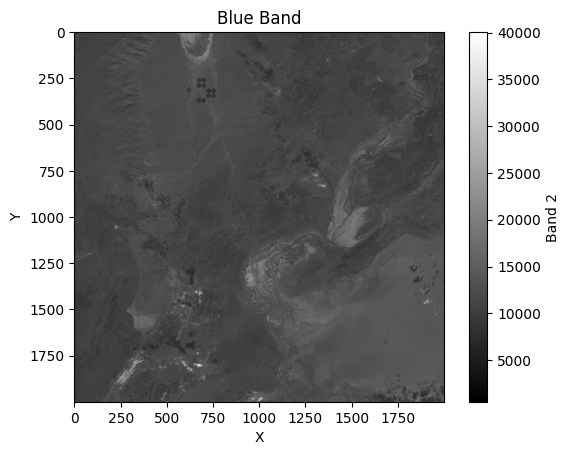

In [4]:
imgs = np.empty((11,2000,2000))
for i in range(6):
    with rasterio.open(raster_files[i]) as src:
        nodata_value = src.nodata
        window = rasterio.windows.Window.from_slices((1000,3000),(1000,3000))
        img = src.read(1, window=window)
        imgs[i,:,:] = np.where(img == src.nodata, np.nan, img)

b6 = imgs[4,:,:]
b7 = imgs[5,:,:]
# Calculate the new raster (B6 / B7)
# Replace 0 values in b6 to avoid division by zero  # Replace with NaN or a small value
CMI = np.divide(b6, b7, out=np.zeros_like(b6, dtype=float), where=b7 != 0)
imgs[6,:,:] = CMI

print(f'Landsat bands shape: {imgs.shape}')
plt.imshow(imgs[0,:,:], cmap='grey')
plt.colorbar(label='Band 2')
plt.title('Blue Band')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

**Figure 1.** Landsat image of a region northeast of Reno, Nevada. Band 2, which ranges the electromagnetic spectrum corresponding to blue light, is displayed in grey scale.

A new addition to the final edition, different from the EDA preprocessing, is using global mean subtraction on the DEM so relative elevation is used instead of true. This is needed once models are applied to the Iceland DEM which has a different range of elevation values.

DEM new shape: (2000, 2000)
Fault new shape: (2000, 2000)
Fault pixel count: 43785


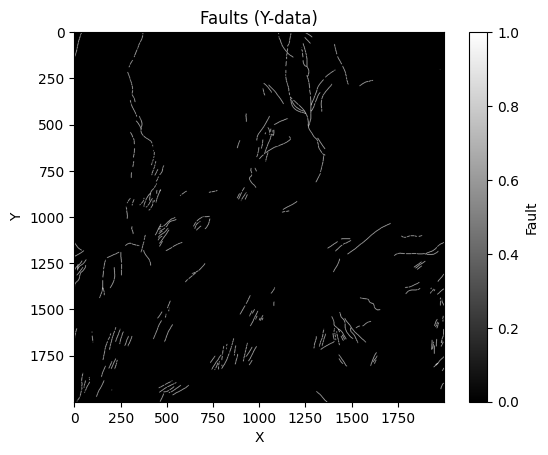

In [5]:
from scipy.ndimage import uniform_filter
reference_band = raster_files[0]
with rasterio.open(reference_band) as ref:
    ref_transform = ref.transform
    ref_crs = ref.crs
    ref_width = ref.width
    ref_height = ref.height

dem = raster_files[6]
with rasterio.open(dem) as src:
    nodata_value = src.nodata
    dem_resampled = np.empty((ref_height, ref_width), dtype=np.float32)
    src.read(1, out = dem_resampled,
                        resampling=Resampling.bilinear)
    dem_clipped = dem_resampled[1000:3000, 1000:3000]
    dem_clipped = np.where(dem_clipped == nodata_value, np.nan, dem_clipped)
    nevada_mean = np.nanmean(dem_clipped)
    nevada_dem = dem_clipped - nevada_mean
print(f'DEM new shape: {dem_clipped.shape}')

fault_raster = raster_files[7]
with rasterio.open(fault_raster) as src:
    nodata_value = src.nodata
    fault_resampled = np.empty((ref_height, ref_width), dtype=np.float32)
    src.read(1, out = fault_resampled,
                        resampling=Resampling.nearest)
    fault_clipped = fault_resampled[1000:3000, 1000:3000]
    fault_clipped = np.where(fault_clipped == nodata_value, np.nan, fault_clipped)
print(f'Fault new shape: {fault_clipped.shape}')

from scipy.ndimage import binary_dilation
fault_mask = (fault_clipped == 1)
buffer_size = 1  # Set the desired buffer size in pixels
buffered_mask = binary_dilation(fault_mask, iterations=buffer_size)
fault_clipped[buffered_mask] = 1
print(f'Fault pixel count: {np.sum(fault_clipped==1)}')
imgs[7,:,:] = nevada_dem
imgs[10,:,:] = fault_clipped

plt.imshow(imgs[10,:,:], cmap='grey')
plt.colorbar(label='Fault')
plt.title('Faults (Y-data)')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

**Figure 2.** Fault lines within the region, marked by a value of 1.

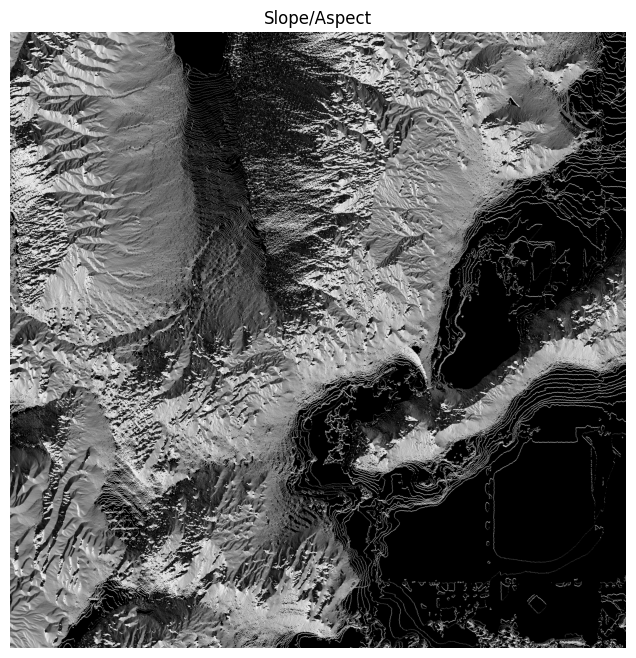

In [6]:
# Calculate resolution
x_res = 30  # Pixel width
y_res = -30  # Pixel height (negative)

# Compute gradients
gy, gx = np.gradient(dem_clipped, y_res, x_res)

# Compute aspect in degrees
aspect = np.degrees(np.arctan2(gy, -gx))
slope = np.arctan(np.sqrt(gx**2 + gy**2)) * (180 / np.pi)

imgs[8,:,:] = aspect
imgs[9,:,:] = slope

slope_aspect_image = np.dstack([aspect,slope])
plt.figure(figsize=(8, 8))
plt.imshow(slope_aspect_image[:, :, 0], cmap='grey')
plt.title('Slope/Aspect')
plt.axis('off')
plt.show()

**Figure 3.** Slope and Aspect, which are derived from a digital elevation model, are stacked and displayed.

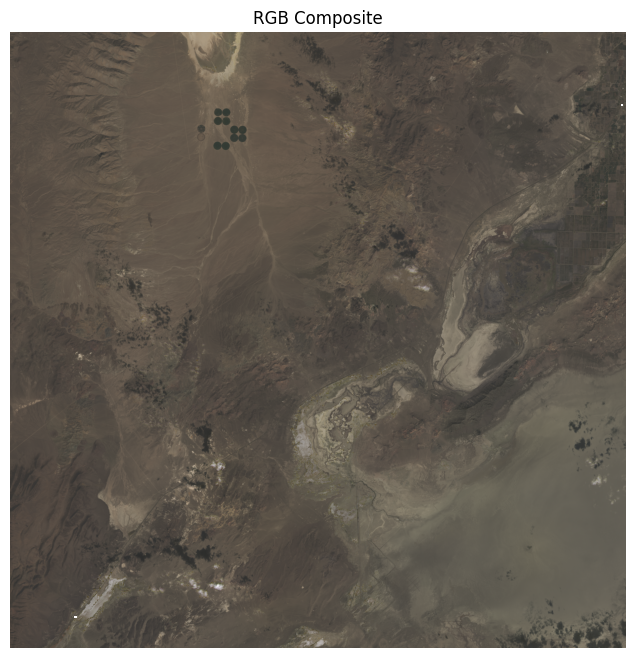

In [7]:
rgb_bands = [imgs[2, :, :], imgs[1, :, :], imgs[0, :, :]]

rgb_image = np.dstack(rgb_bands)
rgb_norm = (rgb_image - np.nanmin(rgb_image)) / (np.nanmax(rgb_image) - np.nanmin(rgb_image))
# Plot the RGB image
plt.figure(figsize=(8, 8))  # Adjust figure size if needed
plt.imshow(rgb_norm)
plt.title('RGB Composite')
plt.axis('off')  # Optional: Turn off axes
plt.show()

**Figure 4.** Red, green, and blue bands are stacked as a 3 color composite to show the visible light spectrum, which a human would see from the same angle.

### Imported Libraries

In [8]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, roc_curve, auc, confusion_matrix
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import xarray as xr
from imblearn.under_sampling import RandomUnderSampler
from sklearn.decomposition import PCA
from sklearn.model_selection import PredefinedSplit
import xgboost as xgb
import seaborn as sns

### Dimensionality Reduction

A reduced dataset will be produced using PCA to compare against the original dataset.

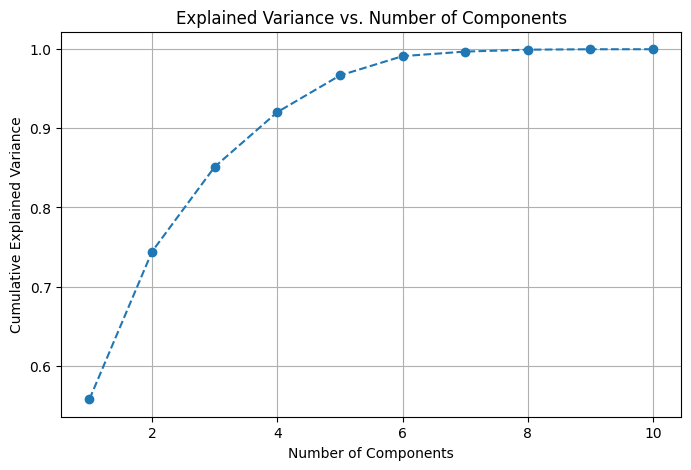

In [9]:
X_data = imgs[0:10,:,:].copy()
X_masked = np.nan_to_num(X_data)
X_flat = X_masked.reshape(X_data.shape[0], -1).T
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_flat)
# Fit PCA on full dataset
pca = PCA()
pca.fit(X_scaled)

# Compute cumulative explained variance
explained_variance = np.cumsum(pca.explained_variance_ratio_)

# Plot
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o', linestyle='--')
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("Explained Variance vs. Number of Components")
plt.grid()
plt.show()

**Figure 5.** PCA explained variance across a range of components. 5 components results in a total explained variance of ~96%, this number of components will be used for performance comparison.

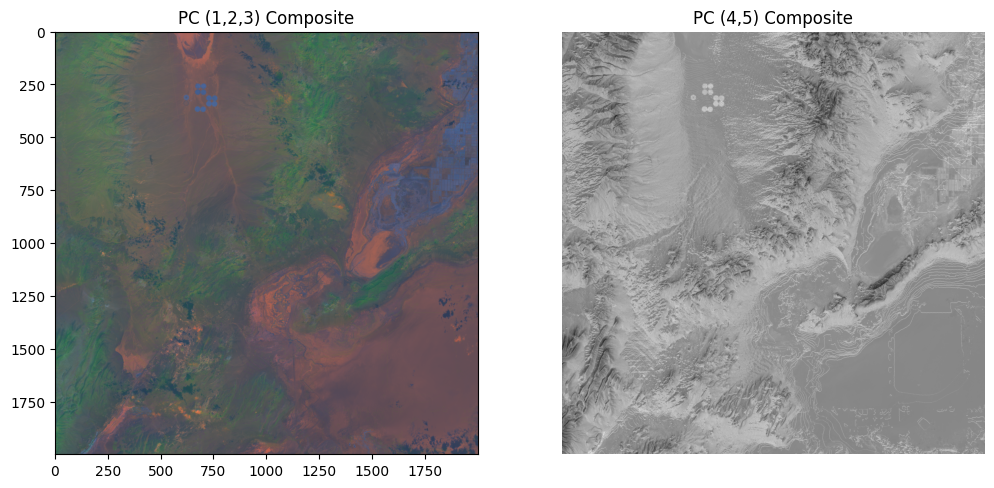

In [10]:
pca = PCA(n_components=5)
pca_data = pca.fit_transform(X_scaled)
X_pca = pca_data.reshape(X_data.shape[1], X_data.shape[2], 5)
X_pca_rgb = np.dstack([X_pca[:, :, 0], X_pca[:, :, 1], X_pca[:, :, 2]])
X_pca_rgb_norm = (X_pca_rgb - np.nanmin(X_pca_rgb)) / (np.nanmax(X_pca_rgb) - np.nanmin(X_pca_rgb))
X_pca_2 = np.dstack([X_pca[:, :, 3], X_pca[:, :, 4]])
X_pca_2_norm = (X_pca_2 - np.nanmin(X_pca_2)) / (np.nanmax(X_pca_2) - np.nanmin(X_pca_2))

fig, ax = plt.subplots(1, 2, figsize=(12, 6))

ax[0].imshow(X_pca_rgb_norm)
ax[1].imshow(X_pca_2_norm[:, :, 0], cmap='grey')
ax[0].set_title('PC (1,2,3) Composite')
ax[1].set_title('PC (4,5) Composite')
plt.axis('off')  # Optional: Turn off axes
plt.show()

**Figure 6.** RGB composite of the first three components and grayscale of an overlay of the last two components.

### Splitting Data

Due to spatial autocorrelation, data cannot be randomly split into training and testing datasets. This would cause the model to catch a glimpse of the test data when training since each data point is not independent from its neighbors. We'll use a checkerboard method to split the data into training, validation, and testing. Each dataset is flattened, and nan values are removed. An option to combine training and validation sets is put into the function below to output a larger training dataset.

In [11]:
def make_checkerboard(board_size, square_size, val=False):
    rows, cols = board_size
    sq_rows, sq_cols = square_size
    row_indices = np.arange(rows) // sq_rows
    col_indices = np.arange(cols) // sq_cols
    if val == False:
        checkerboard = (row_indices[:, np.newaxis] + col_indices) % 2
    else:
        checkerboard = (row_indices[:, np.newaxis] + col_indices) % 3
    return checkerboard.astype('float32')

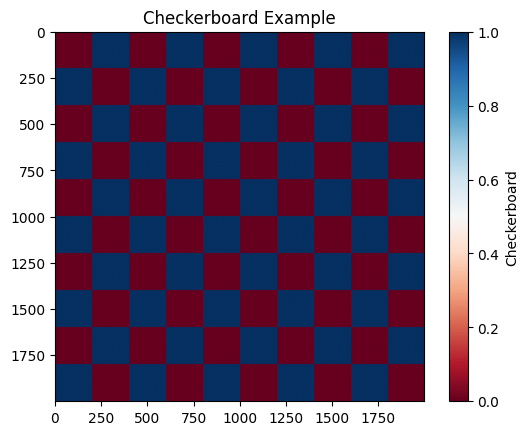

<Figure size 600x600 with 0 Axes>

In [12]:
checker = make_checkerboard(imgs[0,:,:].shape,(200,200))
plt.imshow(checker,cmap='RdBu')
plt.title('Checkerboard Example')
plt.colorbar(label='Checkerboard')
plt.figure(figsize=(6,6))
plt.show()

**Figure 7.** A 10x10 checkerboard over the same extent as the Nevada dataset. Blue squares will define the training data while the red will define the test data. This helps prevent data leakage into the training model.

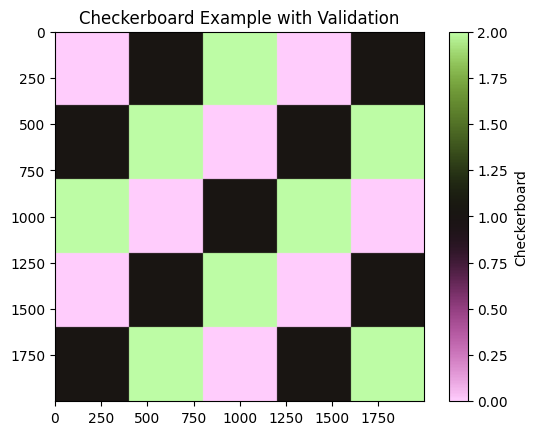

In [13]:
checker = make_checkerboard(imgs[0,:,:].shape,(400,400),val=True)
plt.imshow(checker,cmap='vanimo')
plt.title('Checkerboard Example with Validation')
plt.colorbar(label='Checkerboard')

**Figure 8.** A 5x5 checkerboard but with 3 classifications to allow for a validation dataset. Black would be training, green would be validation, and pink would be testing.

In [14]:
def checkered_spilt(X, y, checker, val=False, combine=False):
    X_flat = X.reshape(X.shape[0], -1).T
    y_flat = y.flatten()

    X_train = X_flat[checker.flatten() == 1]
    y_train = y_flat[checker.flatten() == 1]

    X_test = X_flat[checker.flatten() == 0]
    y_test = y_flat[checker.flatten() == 0]

    check_train = np.column_stack((X_train, y_train))
    check_test = np.column_stack((X_test, y_test))

    nan_indices_train = np.isnan(check_train).any(axis=1)
    nan_indices_test = np.isnan(check_test).any(axis=1)

    check_train_filtered = check_train[~nan_indices_train]
    check_test_filtered = check_test[~nan_indices_test]

    X_train = check_train_filtered[:, :-1]
    y_train = check_train_filtered[:, -1]

    X_test = check_test_filtered[:, :-1]
    y_test = check_test_filtered[:, -1]

    if val == True:
        X_val = X_flat[checker.flatten() == 2]
        y_val = y_flat[checker.flatten() == 2]
        check_val = np.column_stack((X_val, y_val))
        nan_indices_val = np.isnan(check_val).any(axis=1)
        check_val_filtered = check_val[~nan_indices_val]
        X_val = check_val_filtered[:, :-1]
        y_val = check_val_filtered[:, -1]

        if combine == True:
            X_train = np.concatenate((X_train, X_val), axis=0)
            y_train = np.concatenate((y_train, y_val), axis=0)
            print(f'Training X,y shape: {X_train.shape}, {y_train.shape}')
            print(f'Testing X,y shape: {X_test.shape}, {y_test.shape}')
            return X_train, y_train, X_test, y_test
        else:
            print(f'Training X,y shape: {X_train.shape}, {y_train.shape}')
            print(f'Validation X,y shape: {X_val.shape}, {y_val.shape}')
            print(f'Testing X,y shape: {X_test.shape}, {y_test.shape}')
            return X_train, y_train, X_test, y_test, X_val, y_val
    else:
        print(f'Training X,y shape: {X_train.shape}, {y_train.shape}')
        print(f'Testing X,y shape: {X_test.shape}, {y_test.shape}')
        return X_train, y_train, X_test, y_test


### Feature Scaling and Resampling

Scaling combats model bias to large values. Standardization and normalization were initially tested and found to have similar results, but normalization was ultimately chosen due to slightly better performance.

Because the quantity of pixels classified as faults is far outclassed by the quantity of no fault pixels, resampling is necessary to scale the training dataset. Training data will be randomly under sampled to output an almost equal quantity of both classes.

These methods are applied to both the original and PCA datasets. Scalers are saved to apply to application datasets.

In [15]:
def resample_scale(X_train, y_train, X_test, X_val=None):
    undersampler = RandomUnderSampler(sampling_strategy='auto', random_state=42)
    X_train_und, y_train_und = undersampler.fit_resample(X_train, y_train)

    scaler = MinMaxScaler()
    scaler.fit(X_train_und)
    X_train_scaled = scaler.transform(X_train_und)
    X_test_scaled = scaler.transform(X_test)
    if X_val is not None:
        X_val_scaled = scaler.transform(X_val)
        print(f'Resampled and Normalized training X shape: {X_train_scaled.shape}')
        return X_train_scaled, y_train_und, X_test_scaled, X_val_scaled, scaler
    else:
        print(f'Resampled and Normalized training X shape: {X_train_scaled.shape}')
        return X_train_scaled, y_train_und, X_test_scaled, scaler


In [16]:
X_data = imgs[0:10,:,:].copy()
pca_data = np.transpose(X_pca, (2, 0, 1))
y_data = imgs[10,:,:].copy()

checker = make_checkerboard(X_data[0,:,:].shape,(100,100),val=True)

X_train, y_train, X_test, y_test = checkered_spilt(X_data, y_data, checker,val=True,combine=True)
pca_train, ypca_train, pca_test, ypca_test = checkered_spilt(pca_data, y_data, checker,val=True,combine=True)

Training X,y shape: (2669998, 10), (2669998,)
Testing X,y shape: (1329980, 10), (1329980,)
Training X,y shape: (2670000, 5), (2670000,)
Testing X,y shape: (1329987, 5), (1329987,)


In [17]:
X_train, y_train, X_test, Orig_scaler = resample_scale(X_train, y_train, X_test)
pca_train, ypca_train, pca_test, pca_scaler = resample_scale(pca_train, ypca_train, pca_test)

Resampled and Normalized training X shape: (57154, 10)
Resampled and Normalized training X shape: (57154, 5)


### Classifiers

Classification models will be scored by five metrics. The first three are recall, precision, and f1. Recall measures how many true positives were correctly identified for a particular probability threshold. Precision works very similarly but instead measures how often true negatives are predicted. F1 combines the score from both. The last two are roc curve and auc. Roc curve displays the true positive vs false positive rate, where auc is the area under this curve.

Different projects will require more well-tuned recall or precision based on the desired output, though both are still desired to be high for all projects. In this project we care mostly about finding faults so recall will be the more important metric; however, higher precision will allow easier interpretation of probability maps.

Probability maps will be generated for better performing models to show likelihood of faults within the extent. In order to do this, models that do not output predicted probabilities cannot be used, or, in the case of SVM, including predicted probabilities greatly increases the time it takes for the model to run.

Based on the first pass, Gradient Boost, an ensemble method, was the highest performing so other ensemble methods will be compared here. The three models tested are Gradient Boost, Random Forest, and XG Boost.

In [18]:
def evaluate_model(model, X_test, y_test, model_name):
    y_prob = model.predict_proba(X_test)[:, 1]
    thresholds = [0.1,0.2,0.3,0.4,0.5]

    recalls = []
    precisions = []
    f1s = []

    for threshold in thresholds:
        y_pred = (y_prob >= threshold).astype(int)
        recall = recall_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)

        recalls.append(recall)
        precisions.append(precision)
        f1s.append(f1)

        print(f"Threshold: {threshold:.1f}")
        print(f"  Recall, Precision, F1-Score: {recall:.4f}, {precision:.4f}, {f1:.4f}")
        print("")

   # Plot metrics vs. thresholds
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.bar(thresholds, recalls, width=0.05, label='Recall')
    plt.xlabel('Probability Threshold')
    plt.ylabel('Recall')
    plt.title(f'Recall vs. Thresholds ({model_name})')
    plt.xticks(thresholds)
    plt.legend()

    # Plot ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    plt.subplot(1, 2, 2)
    plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line for random chance
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve ({model_name})')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [19]:
def model_over_checkers(X, y, grid_list, model):
    for grid_size in grid_list:
        checker = make_checkerboard((2000,2000),(grid_size,grid_size),val=True)
        X_train, y_train, X_test, y_test = checkered_spilt(X, y, checker,val=True,combine=True)
        undersampler = RandomUnderSampler(sampling_strategy='auto', random_state=42)
        X_train, y_train = undersampler.fit_resample(X_train, y_train)
        scaler = MinMaxScaler()
        scaler.fit(X_train)
        X_train_scaled = scaler.transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        model.fit(X_train_scaled, y_train)

        y_prob = model.predict_proba(X_test_scaled)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'({grid_size},{grid_size}) AUC = {roc_auc:.2f}')
    plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line for random chance
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve of Different Checker Square Sizes')
    plt.legend()
    plt.figure(figsize=(10, 8))
    plt.show()

In [20]:
def model_over_checkers_ytestShuffle(X, y, grid_list, model):
    for grid_size in grid_list:
        checker = make_checkerboard((2000,2000),(grid_size,grid_size),val=True)
        X_train, y_train, X_test, y_test = checkered_spilt(X, y, checker,val=True,combine=True)
        undersampler = RandomUnderSampler(sampling_strategy='auto', random_state=42)
        X_train, y_train = undersampler.fit_resample(X_train, y_train)
        scaler = MinMaxScaler()
        scaler.fit(X_train)
        X_train_scaled = scaler.transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        y_shuffled = np.random.permutation(y_test)

        model.fit(X_train_scaled, y_train)

        y_prob = model.predict_proba(X_test_scaled)[:, 1]
        fpr, tpr, _ = roc_curve(y_shuffled, y_prob)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'({grid_size},{grid_size}) AUC = {roc_auc:.2f}')
    plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line for random chance
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve of Above Square Sizes with Shuffle of Y-Test')
    plt.legend()
    plt.figure(figsize=(10, 8))
    plt.show()

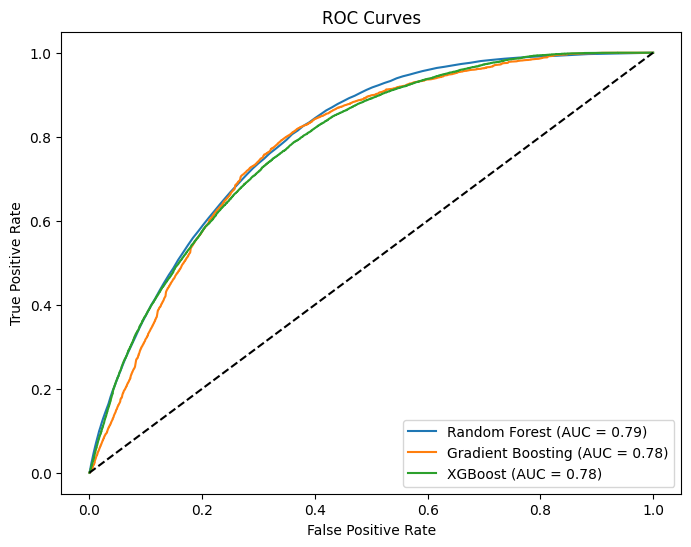

Random Forest: Recall = 0.62, Precision = 0.03, F1-Score = 0.06
Gradient Boosting: Recall = 0.84, Precision = 0.02, F1-Score = 0.05
XGBoost: Recall = 0.66, Precision = 0.03, F1-Score = 0.06


In [21]:
rf_classifier = RandomForestClassifier(random_state=42)
gb_classifier = GradientBoostingClassifier(random_state=42)
xgb_classifier = xgb.XGBClassifier(random_state=42)

# Fit classifiers
rf_classifier.fit(X_train, y_train)
gb_classifier.fit(X_train, y_train)
xgb_classifier.fit(X_train, y_train)

# Get predicted probabilities
rf_probs = rf_classifier.predict_proba(X_test)[:, 1]
gb_probs = gb_classifier.predict_proba(X_test)[:, 1]
xgb_probs = xgb_classifier.predict_proba(X_test)[:, 1]

# Calculate ROC curve and AUC
rf_fpr, rf_tpr, _ = roc_curve(y_test, rf_probs)
rf_auc = auc(rf_fpr, rf_tpr)
gb_fpr, gb_tpr, _ = roc_curve(y_test, gb_probs)
gb_auc = auc(gb_fpr, gb_tpr)
xgb_fpr, xgb_tpr, _ = roc_curve(y_test, xgb_probs)
xgb_auc = auc(xgb_fpr, xgb_tpr)

# Plot ROC curves
plt.figure(figsize=(8, 6))
plt.plot(rf_fpr, rf_tpr, label=f'Random Forest (AUC = {rf_auc:.2f})')
plt.plot(gb_fpr, gb_tpr, label=f'Gradient Boosting (AUC = {gb_auc:.2f})')
plt.plot(xgb_fpr, xgb_tpr, label=f'XGBoost (AUC = {xgb_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line for random chance
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend()
plt.show()

# Calculate and print recall, precision, and F1 score
for name, probs in [('Random Forest', rf_probs), ('Gradient Boosting', gb_probs), ('XGBoost', xgb_probs)]:
    y_pred = (probs >= 0.5).astype(int)  # Assuming 0.5 threshold
    recall = recall_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    print(f'{name}: Recall = {recall:.2f}, Precision = {precision:.2f}, F1-Score = {f1:.2f}')

**Figure 9.** Our 5 scoring metrics are compared for the base hyperparameters of all three models. Gradient Boost has the best recall at a threshold of 0.5, but the other two models equally outperforming just slightly in precision and f1. Random Forest produces a slightly higher auc score of 0.79 compared to other 2 models.

### Gradient Boosting Classifier

Gradient Boost is an ensemble method that uses the boosting method on its decision trees. Boosting works by building shallow trees sequentially and correcting errors of the previous tree into new trees.

To evaluate performance and tune the most optimized model, we'll first compare different checkerboard sizes on GBs base hyperparameters, we'll then check for data leakage in the checker sizes before determining the best one to use. After determining an optimized split dataset, we'll evaluate model performance over a range of hyperparameters to further optimize. The best performing parameters will be used for a final evaluation.

Training X,y shape: (2666693, 10), (2666693,)
Testing X,y shape: (1333285, 10), (1333285,)
Training X,y shape: (2664991, 10), (2664991,)
Testing X,y shape: (1334987, 10), (1334987,)
Training X,y shape: (2669998, 10), (2669998,)
Testing X,y shape: (1329980, 10), (1329980,)
Training X,y shape: (2639978, 10), (2639978,)
Testing X,y shape: (1360000, 10), (1360000,)
Training X,y shape: (2500000, 10), (2500000,)
Testing X,y shape: (1499978, 10), (1499978,)


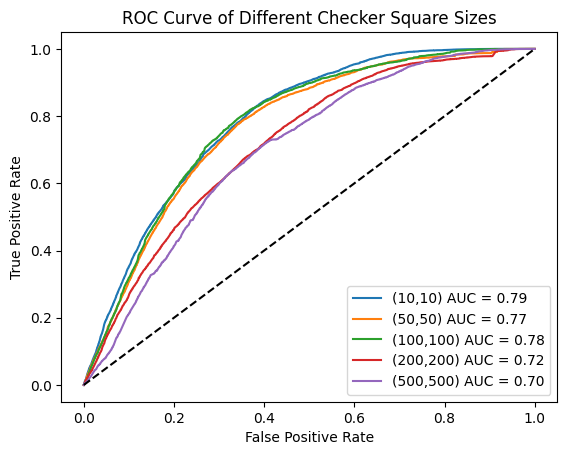

<Figure size 1000x800 with 0 Axes>

In [22]:
grid_list = [10,50,100,200,500]
model_gbc = GradientBoostingClassifier(random_state=42)
model_over_checkers(X_data, y_data, grid_list, model_gbc)

**Figure 10.** Checkerboard sizes of (100,100) and (10,10) performed the best but we need to make sure they don't allow data leakage. Data leakage would produce overfitting to our Nevada extent which would diminish results in datasets the model is later applied to like our Iceland extent.

To check for data leakage for these checker sizes, we'll shuffle our y-test data, leaving x-data unshuffled, and evaluate performance. With no data leakage we expect the performance to be terrible (auc values of 0.5), but if data leakage is present, the model will still show better performance.

Training X,y shape: (2666693, 10), (2666693,)
Testing X,y shape: (1333285, 10), (1333285,)
Training X,y shape: (2664991, 10), (2664991,)
Testing X,y shape: (1334987, 10), (1334987,)
Training X,y shape: (2669998, 10), (2669998,)
Testing X,y shape: (1329980, 10), (1329980,)
Training X,y shape: (2639978, 10), (2639978,)
Testing X,y shape: (1360000, 10), (1360000,)
Training X,y shape: (2500000, 10), (2500000,)
Testing X,y shape: (1499978, 10), (1499978,)


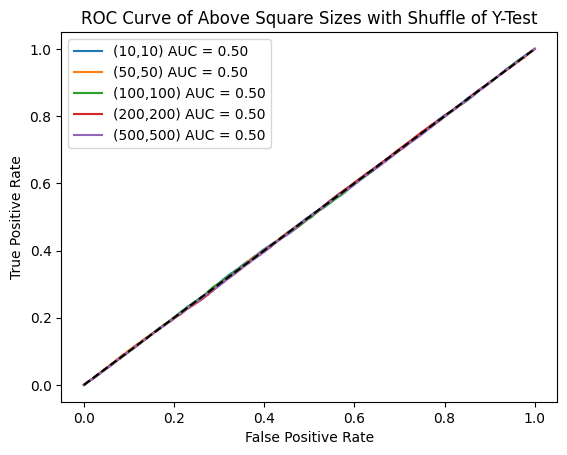

<Figure size 1000x800 with 0 Axes>

In [23]:
grid_list = [10,50,100,200,500]
model_gbc = GradientBoostingClassifier(random_state=42)
model_over_checkers_ytestShuffle(X_data, y_data, grid_list, model_gbc)

**Figure 11.** All checker sizes tested show no data leakage with this test. Checker sizes of (100,100) will still be used just in case and since performance is not significantly different from (10,10).

With checker sizes set, next is hyperparameter optimization which will be tested using grid search. Grid search takes a list of hyperparameter values to iteratively test. 3 values for two parameters would have a total of 3x3, or 9, models tested. In Gradient Boost, max depth and learning rate are the more impactful hyperparameters and are the ones compared here. Grid search is run on pca data since it has less features leading to quicker output. **This process will take a few minutes**

In [24]:
split_index = [-1] * len(pca_train) + [0] * len(pca_test)
pds = PredefinedSplit(test_fold=split_index)

X = np.concatenate((pca_train, pca_test), axis=0)
y = np.concatenate((ypca_train, ypca_test), axis=0)
param_grid = {
    'max_depth': [3, 5, 7],  # Tree depths to search
    'learning_rate': [0.01, 0.1, 0.2],  # Learning rates to search
}

model_gbc = GradientBoostingClassifier(random_state=42)
grid_search = GridSearchCV(
    estimator=model_gbc,
    param_grid=param_grid,
    scoring='roc_auc',
    cv=pds,
    n_jobs=-1,
)
grid_search.fit(X,y)
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)
best_model_gbc = grid_search.best_estimator_

Best Parameters: {'learning_rate': 0.1, 'max_depth': 7}
Best Score: 0.7499355635782673


A learning rate of 0.1, which is the base, and max depth of 7 performed the best. We'll evaluate our new model further on both the original and PCA datasets.

Threshold: 0.1
  Recall, Precision, F1-Score: 0.9596, 0.0166, 0.0327

Threshold: 0.2
  Recall, Precision, F1-Score: 0.9145, 0.0193, 0.0378

Threshold: 0.3
  Recall, Precision, F1-Score: 0.8667, 0.0219, 0.0428

Threshold: 0.4
  Recall, Precision, F1-Score: 0.7916, 0.0247, 0.0479

Threshold: 0.5
  Recall, Precision, F1-Score: 0.6917, 0.0279, 0.0537



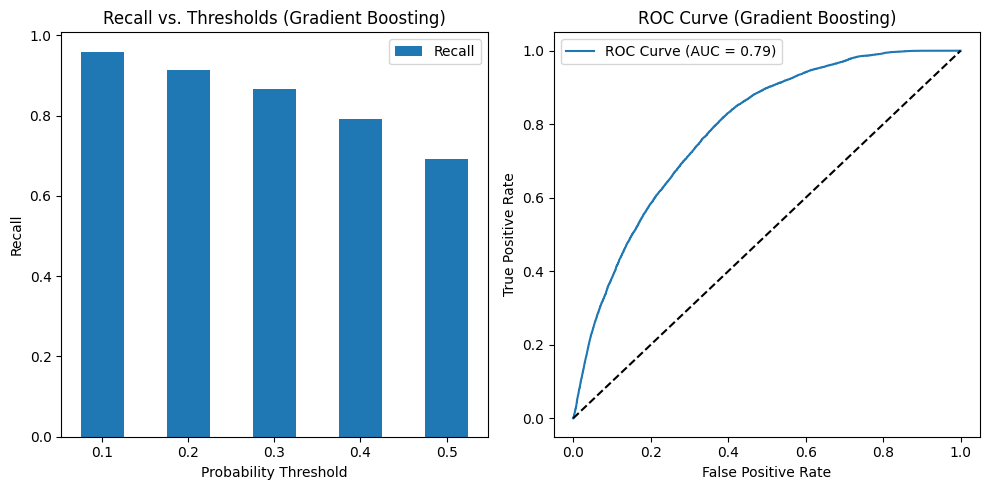

In [25]:
model_gbc = GradientBoostingClassifier(random_state=42,max_depth=7)

model_gbc.fit(X_train, y_train)
evaluate_model(model_gbc, X_test, y_test, 'Gradient Boosting')


**Figure 12.** Recall, precision, and f1 differ depending on what probability threshold the predicted output uses. Recall increases over lower thresholds up to 0.96 at 10% probability.

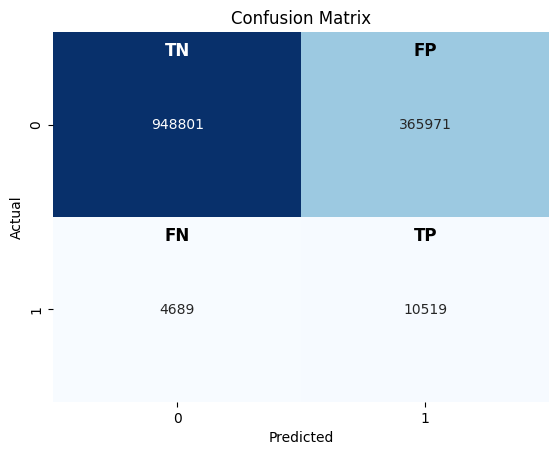

In [26]:
y_prob = model_gbc.predict(X_test)
y_pred = (y_prob > 0.5).astype(int)
cm = confusion_matrix(y_test, y_pred)
ax = sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)

# Add labels for TP, TN, FP, FN
ax.set_xlabel("Predicted")
ax.set_ylabel("Actual")
ax.set_title("Confusion Matrix")

# Add annotations (TP, TN, FP, FN)
ax.text(0.5, 0.1, 'TN', ha='center', va='center', color='white', fontsize=12, fontweight='bold')
ax.text(1.5, 0.1, 'FP', ha='center', va='center', color='black', fontsize=12, fontweight='bold')
ax.text(0.5, 1.1, 'FN', ha='center', va='center', color='black', fontsize=12, fontweight='bold')
ax.text(1.5, 1.1, 'TP', ha='center', va='center', color='black', fontsize=12, fontweight='bold')


plt.show()

**Figure 13.** The confusion matrix displays true negative (top left), false positive (top right), false negative (bottom left), and true positive (bottom right) at 50% threshold.

Threshold: 0.1
  Recall, Precision, F1-Score: 0.9884, 0.0135, 0.0267

Threshold: 0.2
  Recall, Precision, F1-Score: 0.9580, 0.0158, 0.0310

Threshold: 0.3
  Recall, Precision, F1-Score: 0.9079, 0.0181, 0.0355

Threshold: 0.4
  Recall, Precision, F1-Score: 0.8318, 0.0205, 0.0399

Threshold: 0.5
  Recall, Precision, F1-Score: 0.7265, 0.0233, 0.0451



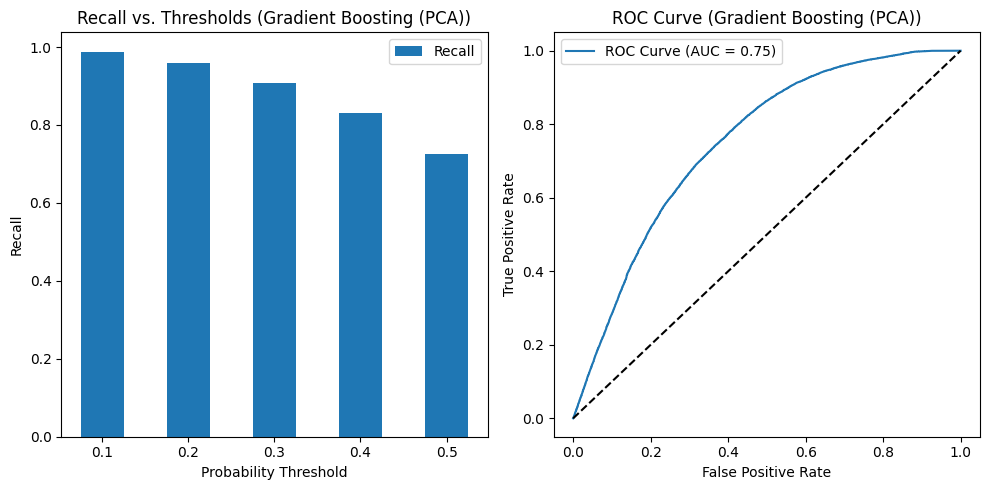

In [27]:
model_gbc_pca = GradientBoostingClassifier(random_state=42,max_depth=7)

model_gbc_pca.fit(pca_train, ypca_train)
evaluate_model(model_gbc_pca, pca_test, ypca_test, 'Gradient Boosting (PCA)')

**Figure 14.** Here is the same analysis on the PCA dataset. Recall values are better but precision and f1 are slightly worse.

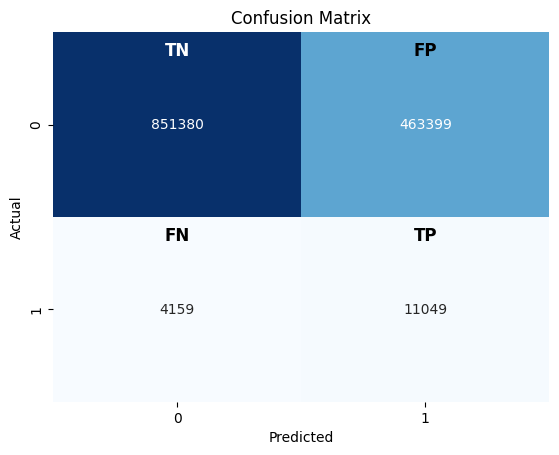

In [28]:
y_prob = model_gbc_pca.predict(pca_test)
y_pred = (y_prob > 0.5).astype(int)
cm = confusion_matrix(ypca_test, y_pred)
ax = sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)

# Add labels for TP, TN, FP, FN
ax.set_xlabel("Predicted")
ax.set_ylabel("Actual")
ax.set_title("Confusion Matrix")

# Add annotations (TP, TN, FP, FN)
ax.text(0.5, 0.1, 'TN', ha='center', va='center', color='white', fontsize=12, fontweight='bold')
ax.text(1.5, 0.1, 'FP', ha='center', va='center', color='black', fontsize=12, fontweight='bold')
ax.text(0.5, 1.1, 'FN', ha='center', va='center', color='black', fontsize=12, fontweight='bold')
ax.text(1.5, 1.1, 'TP', ha='center', va='center', color='black', fontsize=12, fontweight='bold')


plt.show()

**Figure 15.** True negatives are lower than the original dataset, but true positives are higher. It's not apparent yet which dataset output better results, but probability mapping will help illuminate this.

### Probability Mapping

It's clear that the models are performing quite poorly as direct fault indicators. However, there is potential for these models to help locate faults through probability mapping. Probability mapping evaluates the probability of each pixel being a fault and displays a raster as a gradient with higher probabilities indicating more likelihood of a fault being around that location. This can be used by geologists to condense their search for faults or to see where large fault clusters are located.

In [29]:
def get_proba_mask(X_data, model, scaler):
    nodata_mask = np.any(np.isnan(X_data),axis=0)
    X = X_data[:,~nodata_mask]
    X = X.reshape(X.shape[0], -1).T
    X_scaled = scaler.transform(X)

    predictions = model.predict_proba(X_scaled)[:, 1]
    pred_ar = np.zeros(shape=nodata_mask.flatten().shape, dtype='float32')
    pred_ar[np.invert(nodata_mask.flatten())] = predictions
    pred_ar = pred_ar.reshape(nodata_mask.shape)
    pred_ar[nodata_mask] = np.nan
    return pred_ar

In [30]:
pred_gbc = get_proba_mask(X_data, model_gbc, Orig_scaler)
pred_gbc_pca = get_proba_mask(pca_data, model_gbc_pca, pca_scaler)
fault_mask = (imgs[10,:,:] == 1)
fault_mask = binary_dilation(fault_mask, iterations=2)
probability_rgb = plt.cm.viridis(pred_gbc)
probability_rgb[..., :3][fault_mask] = [1, 0, 0]
probability_rgb[..., 3] = 1
probability_rgb_pca = plt.cm.viridis(pred_gbc_pca)
probability_rgb_pca[..., :3][fault_mask] = [1, 0, 0]
probability_rgb_pca[..., 3] = 1

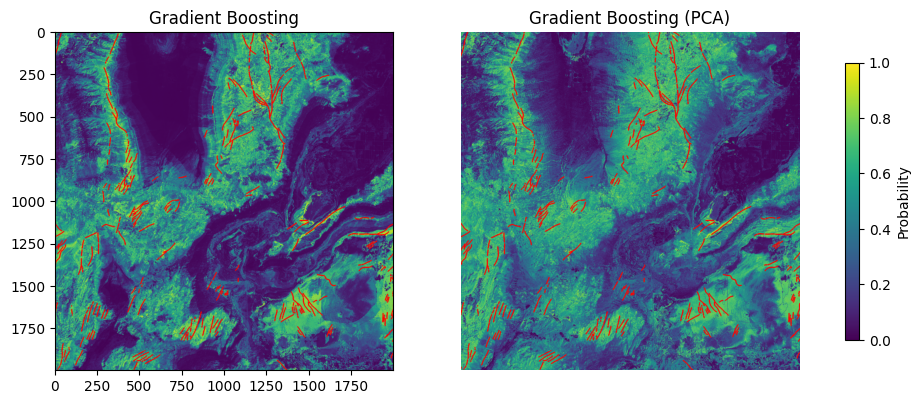

In [31]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
im1 = ax[0].imshow(probability_rgb)
im2 = ax[1].imshow(probability_rgb_pca)
ax[0].set_title('Gradient Boosting')
ax[1].set_title('Gradient Boosting (PCA)')
cbar = fig.colorbar(im1, ax=ax,shrink=0.6)
cbar.set_label('Probability')
plt.axis('off')
plt.show()

**Figure 16.** The probability maps for the two datasets, with true fault lines in red. The maps show that the original data is significantly clearer on where faults are located. It does quite well at generalizing fault lines and clusters. Next, we'll see how this compares to other models.

### XG Boost

XG Boost is an optimized gradient booster which uses regularization to reduce overfitting, depth-wise pruning, parallel processing, and weighted quantile sketch. It's generally better at handling large datasets and is one of the more popular ensemble models used by professional data scientists. This model allows for use of validation datasets for refining the training phase. After grid searching the best hyperparameters, we'll compare this method on both datasets with the original method of combining training and validation. Like Gradient Boost, max depth and learning rate are the more impactful hyperparamters which we'll test.

In [32]:
split_index = [-1] * len(pca_train) + [0] * len(pca_test)
pds = PredefinedSplit(test_fold=split_index)

X = np.concatenate((pca_train, pca_test), axis=0)
y = np.concatenate((ypca_train, ypca_test), axis=0)
param_grid = {
    'max_depth': [4, 6, 8],  # Tree depths to search
    'learning_rate': [0.01, 0.1, 0.2],  # Learning rates to search
}

model_xgb = xgb.XGBClassifier(objective='binary:logistic',random_state=42)
grid_search = GridSearchCV(
    estimator=model_gbc,
    param_grid=param_grid,
    scoring='roc_auc',
    cv=pds,
    n_jobs=-1,
)
grid_search.fit(X,y)
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

Best Parameters: {'learning_rate': 0.1, 'max_depth': 8}
Best Score: 0.7472286023376302


In [33]:
X_data = imgs[0:10,:,:].copy()
pca_data = np.transpose(X_pca, (2, 0, 1))
y_data = imgs[10,:,:].copy()

checker = make_checkerboard(X_data[0,:,:].shape,(100,100),val=True)

X_train, y_train, X_test, y_test, X_val, y_val = checkered_spilt(X_data, y_data, checker,val=True,combine=False)
pca_train, ypca_train, pca_test, ypca_test, pca_val, ypca_val = checkered_spilt(pca_data, y_data, checker,val=True,combine=False)
X_train, y_train, X_test, X_val, Orig_scaler = resample_scale(X_train, y_train, X_test, X_val=X_val)
pca_train, ypca_train, pca_test, pca_val, pca_scaler = resample_scale(pca_train, ypca_train, pca_test, X_val=pca_val)

Training X,y shape: (1340000, 10), (1340000,)
Validation X,y shape: (1329998, 10), (1329998,)
Testing X,y shape: (1329980, 10), (1329980,)
Training X,y shape: (1340000, 5), (1340000,)
Validation X,y shape: (1330000, 5), (1330000,)
Testing X,y shape: (1329987, 5), (1329987,)
Resampled and Normalized training X shape: (28582, 10)
Resampled and Normalized training X shape: (28582, 5)


In [34]:
orig_withval = [X_train, y_train, X_test, y_test, X_val, y_val]
pca_withval = [pca_train, ypca_train, pca_test, ypca_test, pca_val, ypca_val]

In [35]:
X_train, y_train, X_test, y_test = checkered_spilt(X_data, y_data, checker,val=True,combine=True)
pca_train, ypca_train, pca_test, ypca_test = checkered_spilt(pca_data, y_data, checker,val=True,combine=True)
X_train, y_train, X_test,  Orig_scaler = resample_scale(X_train, y_train, X_test)
pca_train, ypca_train, pca_test, pca_scaler = resample_scale(pca_train, ypca_train, pca_test)

orig = [X_train, y_train, X_test, y_test]
pca = [pca_train, ypca_train, pca_test, ypca_test]
datasets = [orig,pca,orig_withval,pca_withval]

Training X,y shape: (2669998, 10), (2669998,)
Testing X,y shape: (1329980, 10), (1329980,)
Training X,y shape: (2670000, 5), (2670000,)
Testing X,y shape: (1329987, 5), (1329987,)
Resampled and Normalized training X shape: (57154, 10)
Resampled and Normalized training X shape: (57154, 5)


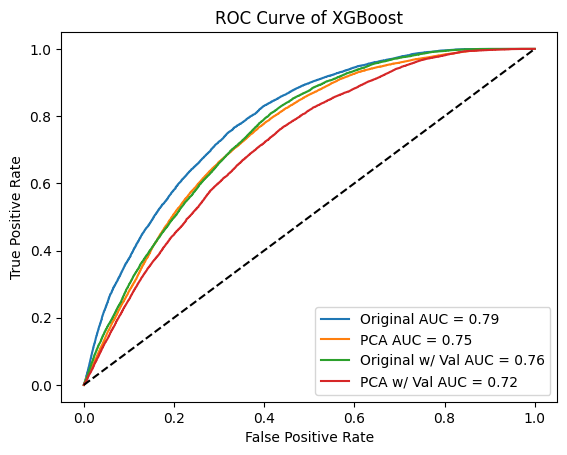

In [36]:
labels = ['Original','PCA','Original w/ Val','PCA w/ Val']
i=0; j=2
for dataset in datasets:
  if len(dataset) == 6:
    label = labels[j]
    X_train, y_train, X_test, y_test, X_val, y_val = dataset[0:6]
    model_xgb = xgb.XGBClassifier(objective='binary:logistic',
                                  random_state=42,
                                  max_depth = 8,
                                  learning_rate = 0.1,
                                  eval_metric='auc')
    model_xgb.fit(X_train, y_train,
                  eval_set=[(X_train,y_train),(X_val,y_val)],
                  verbose=False)
    j+=1
  elif len(dataset) == 4:
    label = labels[i]
    X_train, y_train, X_test, y_test = dataset[0:4]
    model_xgb = xgb.XGBClassifier(objective='binary:logistic',
                                  random_state=42,
                                  max_depth = 6,
                                  learning_rate = 0.2)
    model_xgb.fit(X_train, y_train)
    i+=1
  y_pred_proba = model_xgb.predict_proba(X_test)[:, 1]  # Get probabilities
  fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
  roc_auc = auc(fpr, tpr)
  plt.plot(fpr, tpr, label=f'{label} AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line for random chance
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve of XGBoost')
plt.legend()
plt.show()


**Figure 17.** As with Gradient Boosting, using the original dataset with training and validation combined produces the best results on the base model. We'll use this dataset for further analysis.

Training X,y shape: (2669998, 10), (2669998,)
Testing X,y shape: (1329980, 10), (1329980,)
Resampled and Normalized training X shape: (57154, 10)
Threshold: 0.1
  Recall, Precision, F1-Score: 0.9525, 0.0172, 0.0338

Threshold: 0.2
  Recall, Precision, F1-Score: 0.9123, 0.0199, 0.0389

Threshold: 0.3
  Recall, Precision, F1-Score: 0.8601, 0.0225, 0.0438

Threshold: 0.4
  Recall, Precision, F1-Score: 0.7872, 0.0252, 0.0487

Threshold: 0.5
  Recall, Precision, F1-Score: 0.6913, 0.0284, 0.0546



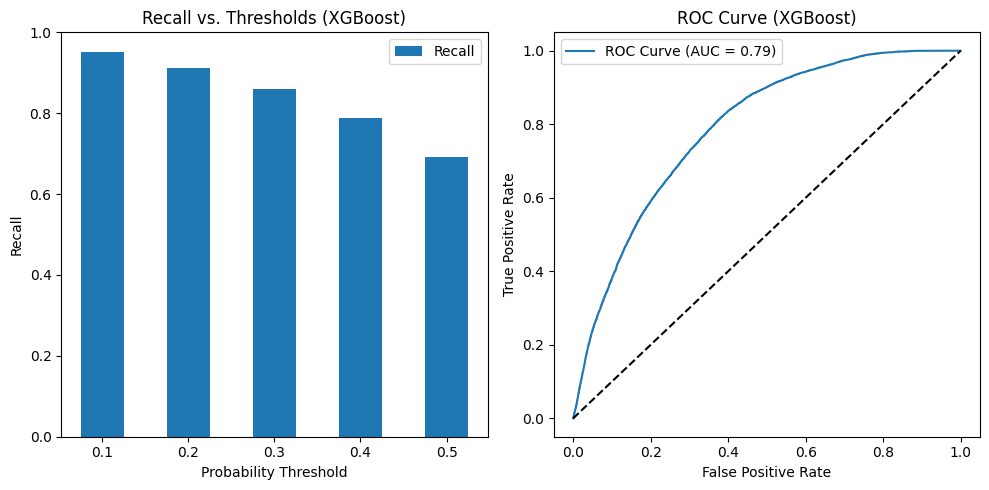

In [37]:
X_train, y_train, X_test, y_test = checkered_spilt(X_data, y_data, checker,val=True,combine=True)
X_train, y_train, X_test,  Orig_scaler = resample_scale(X_train, y_train, X_test)

model_xgb = xgb.XGBClassifier(objective='binary:logistic',
                                  random_state=42,
                                  max_depth = 8,
                                  learning_rate = 0.1)
model_xgb.fit(X_train, y_train)
evaluate_model(model_xgb, X_test, y_test, 'XGBoost')

**Figure 18.** This model produced very similar results to the Gradient Boost model.

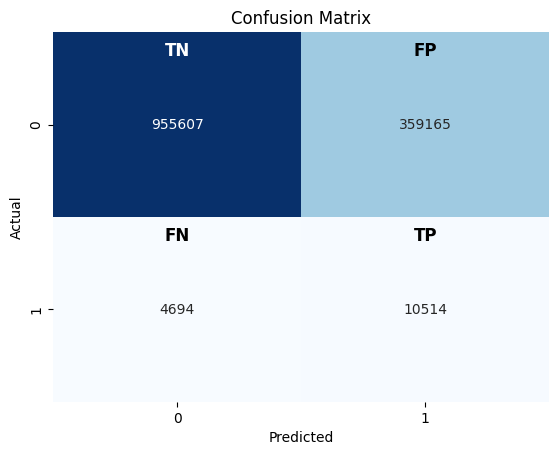

In [38]:
y_pred = model_xgb.predict(X_test)
y_pred = (y_pred > 0.5).astype(int)
cm = confusion_matrix(y_test, y_pred)
ax = sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)

# Add labels for TP, TN, FP, FN
ax.set_xlabel("Predicted")
ax.set_ylabel("Actual")
ax.set_title("Confusion Matrix")

# Add annotations (TP, TN, FP, FN)
ax.text(0.5, 0.1, 'TN', ha='center', va='center', color='white', fontsize=12, fontweight='bold')
ax.text(1.5, 0.1, 'FP', ha='center', va='center', color='black', fontsize=12, fontweight='bold')
ax.text(0.5, 1.1, 'FN', ha='center', va='center', color='black', fontsize=12, fontweight='bold')
ax.text(1.5, 1.1, 'TP', ha='center', va='center', color='black', fontsize=12, fontweight='bold')


plt.show()

**Figure 19.** Compared to the Gradient Boost model, this model produced almost identical false negative and true positive (bottom) values, but true negative values here are greater and false positive values are lower by a respectable amount. This indicates the probability map should be slightly clearer in delineating fault locations.

In [39]:
pred_gbc = get_proba_mask(X_data, model_gbc, Orig_scaler)
pred_xgb = get_proba_mask(X_data, model_xgb, Orig_scaler)
fault_mask = (imgs[10,:,:] == 1)
fault_mask = binary_dilation(fault_mask, iterations=2)
probability_gbc = plt.cm.viridis(pred_gbc)
probability_gbc[..., :3][fault_mask] = [1, 0, 0]
probability_gbc[..., 3] = 1
probability_xgb = plt.cm.viridis(pred_xgb)
probability_xgb[..., :3][fault_mask] = [1, 0, 0]
probability_xgb[..., 3] = 1

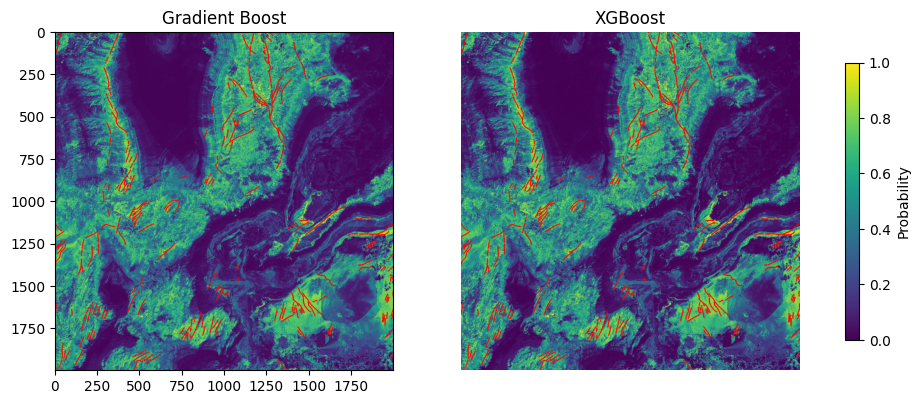

In [40]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
im1 = ax[0].imshow(probability_gbc)
im2 = ax[1].imshow(probability_xgb)
ax[0].set_title('Gradient Boost')
ax[1].set_title('XGBoost')
cbar = fig.colorbar(im1, ax=ax,shrink=0.6)
cbar.set_label('Probability')
plt.axis('off')
plt.show()

**Figure 20.** The difference in the two models probability maps is not very apparent, but the analysis in the previous figure is slightly visible with a refined search.

### Random Forest

Random Forest, while still an ensemble method, works quite differently from the previous two. It uses a bagging method which grows decision trees in parallel by training each tree on a random subset of data and features. Based on the past two models, only the original dataset will be evaluated starting with grid search over a range of max depths and # of estimators. A higher number of estimators generally leads to better performance but also takes more time to run.

In [41]:
split_index = [-1] * len(X_train) + [0] * len(X_test)
pds = PredefinedSplit(test_fold=split_index)

X = np.concatenate((X_train, X_test), axis=0)
y = np.concatenate((y_train, y_test), axis=0)
param_grid = {
    'max_depth': [10, 20, 30],  # Tree depths to search
    'n_estimators': [100,200],
}

model_rf = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(
    estimator=model_rf,
    param_grid=param_grid,
    scoring='roc_auc',
    cv=pds,
    n_jobs=-1,
)
grid_search.fit(X,y)
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

Best Parameters: {'max_depth': 20, 'n_estimators': 200}
Best Score: 0.796818280119135


Training X,y shape: (2669998, 10), (2669998,)
Testing X,y shape: (1329980, 10), (1329980,)
Resampled and Normalized training X shape: (57154, 10)
Threshold: 0.1
  Recall, Precision, F1-Score: 0.9682, 0.0172, 0.0338

Threshold: 0.2
  Recall, Precision, F1-Score: 0.9329, 0.0201, 0.0394

Threshold: 0.3
  Recall, Precision, F1-Score: 0.8749, 0.0231, 0.0450

Threshold: 0.4
  Recall, Precision, F1-Score: 0.7820, 0.0265, 0.0512

Threshold: 0.5
  Recall, Precision, F1-Score: 0.6514, 0.0309, 0.0590



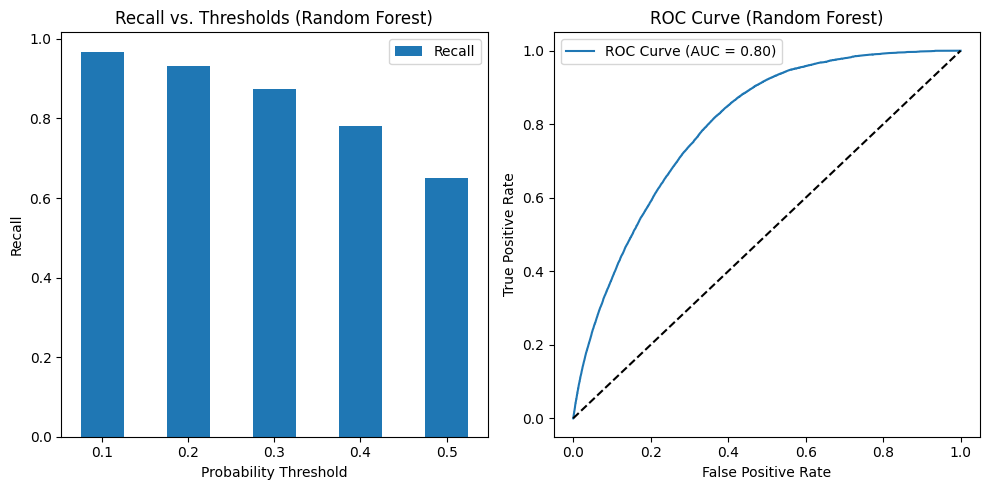

In [42]:
X_train, y_train, X_test, y_test = checkered_spilt(X_data, y_data, checker,val=True,combine=True)
X_train, y_train, X_test,  Orig_scaler = resample_scale(X_train, y_train, X_test)

model_rf = RandomForestClassifier(random_state=42, max_depth=20, n_estimators=200)
model_rf.fit(X_train, y_train)
evaluate_model(model_rf, X_test, y_test, 'Random Forest')

**Figure 21.** Results produced slightly greater scores for all metrics compared to the two previous models.

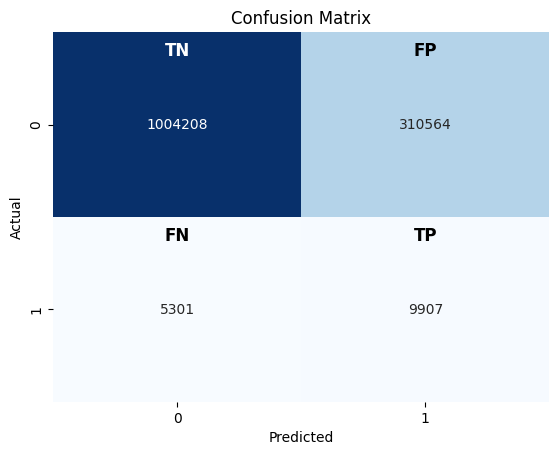

In [43]:
y_pred = model_rf.predict(X_test)
y_pred = (y_pred > 0.5).astype(int)
cm = confusion_matrix(y_test, y_pred)
ax = sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)

# Add labels for TP, TN, FP, FN
ax.set_xlabel("Predicted")
ax.set_ylabel("Actual")
ax.set_title("Confusion Matrix")

# Add annotations (TP, TN, FP, FN)
ax.text(0.5, 0.1, 'TN', ha='center', va='center', color='white', fontsize=12, fontweight='bold')
ax.text(1.5, 0.1, 'FP', ha='center', va='center', color='black', fontsize=12, fontweight='bold')
ax.text(0.5, 1.1, 'FN', ha='center', va='center', color='black', fontsize=12, fontweight='bold')
ax.text(1.5, 1.1, 'TP', ha='center', va='center', color='black', fontsize=12, fontweight='bold')


plt.show()

**Figure 22.** Compared to the previous models confusion matrices, true and false negative values were significantly higher while true and false positive values were significantly lower.

In [44]:
pred_gbc = get_proba_mask(X_data, model_gbc, Orig_scaler)
pred_xgb = get_proba_mask(X_data, model_xgb, Orig_scaler)
pred_rf = get_proba_mask(X_data, model_rf, Orig_scaler)
fault_mask = (imgs[10,:,:] == 1)
fault_mask = binary_dilation(fault_mask, iterations=2)
probability_gbc = plt.cm.viridis(pred_gbc)
probability_gbc[..., :3][fault_mask] = [1, 0, 0]
probability_gbc[..., 3] = 1
probability_xgb = plt.cm.viridis(pred_xgb)
probability_xgb[..., :3][fault_mask] = [1, 0, 0]
probability_xgb[..., 3] = 1
probability_rf = plt.cm.viridis(pred_rf)
probability_rf[..., :3][fault_mask] = [1, 0, 0]
probability_rf[..., 3] = 1

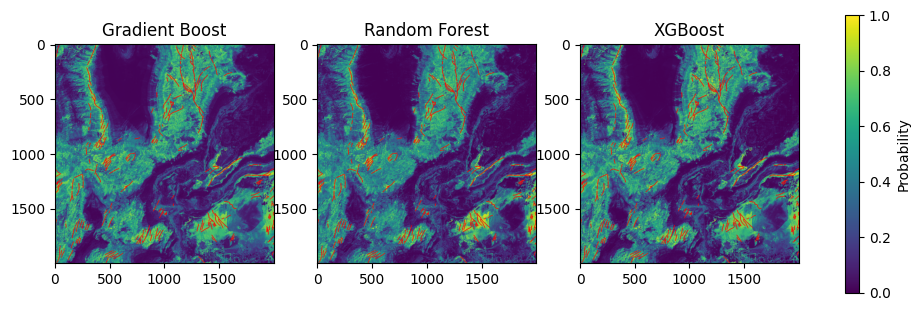

In [45]:
fig, ax = plt.subplots(1, 3, figsize=(12, 6))
im1 = ax[0].imshow(probability_gbc)
im2 = ax[1].imshow(probability_rf)
im3 = ax[2].imshow(probability_xgb)
ax[0].set_title('Gradient Boost')
ax[1].set_title('Random Forest')
ax[2].set_title('XGBoost')
cbar = fig.colorbar(im1, ax=ax,shrink=0.6)
cbar.set_label('Probability')
plt.show()

**Figure 23.** Random Forest's differences between the other probability maps are slightly more apparent. Areas without faults are more clearly shown as empty in this plot.

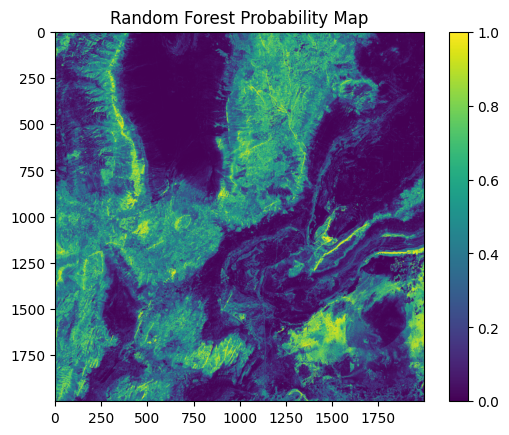

In [46]:
probability_rf = plt.cm.viridis(pred_rf)
plt.imshow(probability_rf)
plt.colorbar()
plt.title('Random Forest Probability Map')
plt.show()

**Figure 24.** Random Forest's probability map is displayed without true fault reference to show high probability classification of fault areas.

### Application (Iceland)

With three well performing models, we can now test them on data with no labels to find faults in a new region. We'll start by loading and visualizing the new region, located in Iceland, then evaluating probability maps for all three models.

In [3]:
raster_files = glob.glob("I*")
raster_files.sort()
print(raster_files)

['IcelandB2.tif', 'IcelandB3.tif', 'IcelandB4.tif', 'IcelandB5.tif', 'IcelandB6.tif', 'IcelandB7.tif', 'IcelandDEM.tif']


Landsat bands shape: (10, 1500, 1500)


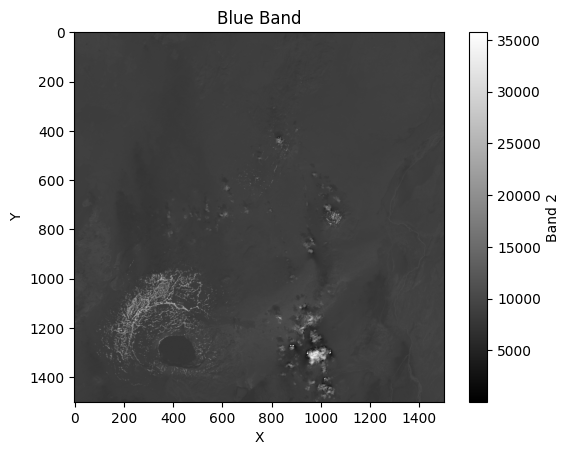

In [4]:
iceland = np.empty((10,1500,1500))
for i in range(6):
    with rasterio.open(raster_files[i]) as src:
        nodata_value = src.nodata
        window = rasterio.windows.Window.from_slices((1000,2500),(1000,2500))
        img = src.read(1, window=window)
        iceland[i,:,:] = np.where(img == src.nodata, np.nan, img)
print(f'Landsat bands shape: {iceland.shape}')
plt.imshow(iceland[0,:,:], cmap='grey')
plt.colorbar(label='Band 2')
plt.title('Blue Band')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

**Figure 25.** Landsat image of a region in Iceland with the Askja Caldera in the bottom left. Band 2, which ranges the electromagnetic spectrum corresponding to blue light, is displayed in grey scale.

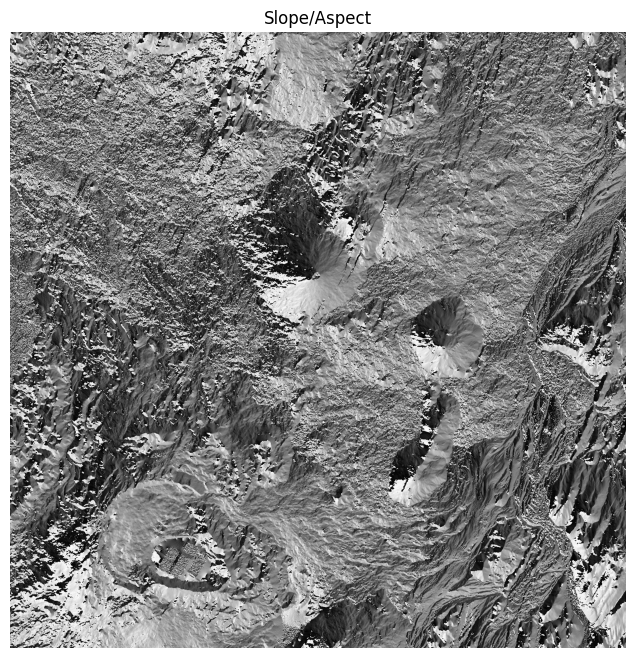

In [5]:
b6 = iceland[4,:,:]
b7 = iceland[5,:,:]
# Calculate the new raster (B6 / B7)
# Replace 0 values in b6 to avoid division by zero  # Replace with NaN or a small value
CMI = np.divide(b6, b7, out=np.zeros_like(b6, dtype=float), where=b7 != 0)
iceland[6,:,:] = CMI
with rasterio.open(raster_files[6]) as src:
    nodata_value = src.nodata
    window = rasterio.windows.Window.from_slices((1000,2500),(1000,2500))
    img = src.read(1, window=window)
    iceland_dem = np.where(img == src.nodata, np.nan, img)
    iceland_mean = np.nanmean(iceland_dem)
    iceland_dem_rel = iceland_dem - iceland_mean
iceland[7,:,:] = iceland_dem_rel
x_res = 30  # Pixel width
y_res = -30  # Pixel height (negative)

# Compute gradients
gy, gx = np.gradient(iceland_dem, y_res, x_res)

# Compute aspect in degrees
aspect = np.degrees(np.arctan2(gy, -gx))
slope = np.arctan(np.sqrt(gx**2 + gy**2)) * (180 / np.pi)

iceland[8,:,:] = aspect
iceland[9,:,:] = slope

slope_aspect_image = np.dstack([aspect,slope])
plt.figure(figsize=(8, 8))
plt.imshow(slope_aspect_image[:, :, 0], cmap='grey')
plt.title('Slope/Aspect')
plt.axis('off')
plt.show()

**Figure 26.** Slope and Aspect, which are derived from a digital elevation model, are stacked and displayed.

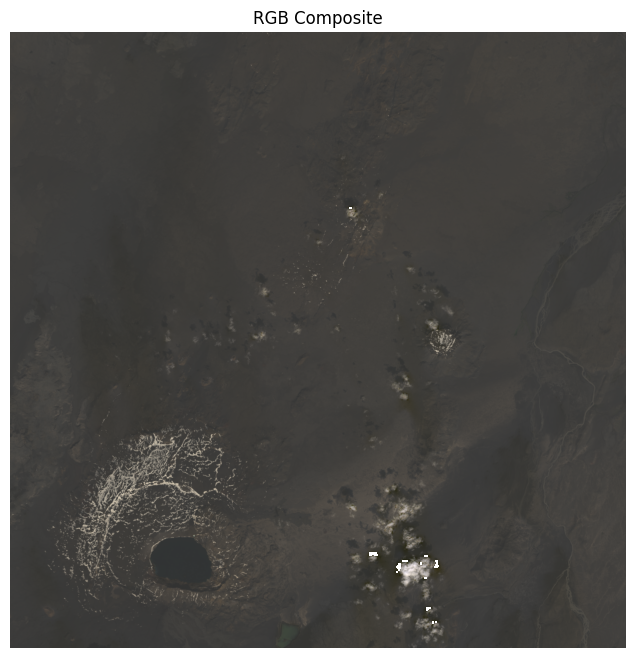

In [50]:
rgb_bands = [iceland[2, :, :], iceland[1, :, :], iceland[0, :, :]]

rgb_image = np.dstack(rgb_bands)
rgb_norm = (rgb_image - np.nanmin(rgb_image)) / (np.nanmax(rgb_image) - np.nanmin(rgb_image))
# Plot the RGB image
plt.figure(figsize=(8, 8))  # Adjust figure size if needed
plt.imshow(rgb_norm)
plt.title('RGB Composite')
plt.axis('off')  # Optional: Turn off axes
plt.show()

**Figure 27.** Red, green, and blue bands are stacked as a 3 color composite to show the visible light spectrum which a human would see from the same angle.

In [51]:
pred_gbc = get_proba_mask(iceland, model_gbc, Orig_scaler)
pred_xgb = get_proba_mask(iceland, model_xgb, Orig_scaler)
pred_rf = get_proba_mask(iceland, model_rf, Orig_scaler)
probability_gbc = plt.cm.viridis(pred_gbc)
probability_xgb = plt.cm.viridis(pred_xgb)
probability_rf = plt.cm.viridis(pred_rf)

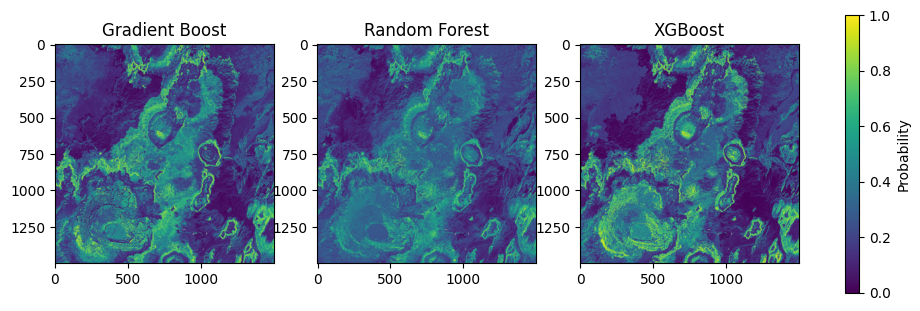

In [52]:
fig, ax = plt.subplots(1, 3, figsize=(12, 6))
im1 = ax[0].imshow(probability_gbc)
im2 = ax[1].imshow(probability_rf)
im3 = ax[2].imshow(probability_xgb)
ax[0].set_title('Gradient Boost')
ax[1].set_title('Random Forest')
ax[2].set_title('XGBoost')
cbar = fig.colorbar(im1, ax=ax,shrink=0.6)
cbar.set_label('Probability')
plt.show()

**Figure 28.** Surprisingly the XG Boost model delineates potential fault zones more clearly, while the best performing model, Random Forest, shows the lowest probabilities across the whole area. Without true fault labels, it's hard to know whether this is due to better performance or worse. It's possible the XG Boost model has greater generalizability where Random Forest doesn't generalize well outside of its original training area. It's also possible there isn't many faults in the region; however, this is highly unlikely due to the significant geologic activity that's happened in the region.

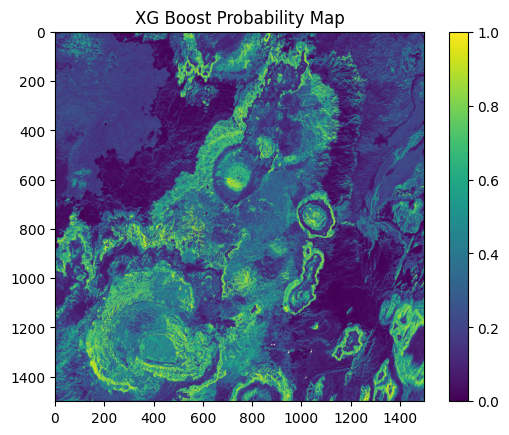

In [53]:
plt.imshow(probability_xgb)
plt.colorbar()
plt.title('XG Boost Probability Map')
plt.show()

**Figure 29.** All models produce essentially the same fault delineations; however, the XG Boost model produces the most well defined. This map can be used by geologists to refine their search for faults in this region.

### Analysis Review

**Which method did you like the most?**

XG Boost was my favorite model. While Random Forest output the best performance for the training data, XG Boost was very similar and when applied to a completely new study area, produced clear results on predicted fault locations.

**Which method did you like the least?**

Gradient Boost was my least favorite model. All results produced similar outputs with the training data, and even though it seems to have done better with the applied dataset than random forest, it is just a simpler version of the more advanced XG Boost. Random Forest, uses different training methods and could be more useful for other projects.

**How did you score these supervised models?**

I scored these models using recall, precision, f1, roc curve, and auc. Accuracy has no application in this project due to the heavy imbalance between classes and most models would likely report very high accuracy.

**Did the output align with your geologic understanding?**

The major fault in this area runs from the north and diverts slightly westward through the Askja caldera. The probability map shows some of this faulting which is encouraging. There is also potential ring faults which can occur around collapsed calderas. The potential faults around the caldera in the lower left are thus expected; however, the other ring faults occur around mountains so it's possible these are model failures due to abrupt elevation change. Overall, the model output expected results that align well with the geology of the region, which has seen extensive tectonic and volcanic activity especially in the recent past.

**Did you hyperparameter tune? Why or why not?**

Hyperparameter tuning was performed using grid search on all three models. Due to the size of the data, grid search took a long time, so it wasn't used for a very detailed search; however, score increases were very slight so an exhaustive search was not necessary.

**How did you split your data? and why does that make sense for this dataset?**

Data was split by checkerboarding, where one set of grids was chosen to be training data, one was chosen as validation, and one was chosen as testing data. This was used because my data is geospatial imagery so breaking apart the data by grid helps prevent data leakage and keeps dependent datapoints together. Training and validation datasets were ultimately merged to provide more training data for the models.

**What did you want to learn more about?**

I wanted to learn more about coding, visualizing, and analyzing geospatial imagery in python, especially using multiple bands/rasters. I have plenty of experience using GIS software, however, python allows more fine tuning of analysis models especially in machine and deep learning. Some of the most important things I learned by working through this project was the importance of proper scaling, splitting, and other preprocessing steps.

**Did you pre-process your data?**

My data required a lot of preprocessing, some of it was done using GIS software for convenience and time saving reasons, but others were done in this notebook. Preprocessing was done in two ways, first was combining multiple datasets into one while manipulating them to be compatible together. The other part was preparing it to be optimized for a machine learning model. Splitting, resampling, and scaling were the most focused on and greatly impacted model performance, even more than hyperparameter tuning. When evaluating the final output on the Iceland data, I realized I also needed to preprocess both my DEMs further by converting true elevation to relative.

**Do all models require pre-processing?**

Yes, all models require preprocessing though not for all data. Many models can handle different types or states of data. Most machine learning models, at the very least, need data in numerical form and without null values, though other types of models may not have these requirements they will have others.